# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [2]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install pymongo[srv]

     |████████████████████████████████| 241 kB 23.1 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install tweepy

     |████████████████████████████████| 65 kB 4.4 MB/s  eta 0:00:01
     |████████████████████████████████| 146 kB 64.5 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [6]:
!pip install twitter

     |████████████████████████████████| 50 kB 7.0 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [7]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [8]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [11]:
client = MongoClient(mongod_connect)
db = client.gp1 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [12]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [13]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [14]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5245782,-77.6333492,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [15]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Mon Nov 29 21:13:22 +0000 2021'
'Mon Nov 29 21:12:30 +0000 2021'
'Mon Nov 29 21:12:13 +0000 2021'
'Mon Nov 29 21:12:01 +0000 2021'
'Mon Nov 29 21:11:41 +0000 2021'
'Mon Nov 29 21:11:08 +0000 2021'
'Mon Nov 29 21:10:38 +0000 2021'
'Mon Nov 29 21:07:49 +0000 2021'
'Mon Nov 29 21:07:01 +0000 2021'
'Mon Nov 29 21:05:03 +0000 2021'
'Mon Nov 29 21:01:42 +0000 2021'
'Mon Nov 29 21:01:07 +0000 2021'
'Mon Nov 29 21:01:07 +0000 2021'
'Mon Nov 29 21:00:53 +0000 2021'
'Mon Nov 29 21:00:07 +0000 2021'
'Mon Nov 29 20:59:00 +0000 2021'
'Mon Nov 29 20:53:07 +0000 2021'
'Mon Nov 29 20:53:00 +0000 2021'
'Mon Nov 29 20:52:30 +0000 2021'
'Mon Nov 29 20:50:12 +0000 2021'
'Mon Nov 29 20:49:10 +0000 2021'
'Mon Nov 29 20:48:06 +0000 2021'
'Mon Nov 29 20:47:17 +0000 2021'
'Mon Nov 29 20:45:40 +0000 2021'
'Mon Nov 29 20:44:05 +0000 2021'
'Mon Nov 29 20:43:25 +0000 2021'
'Mon Nov 29 20:42:11 +0000 2021'
'Mon Nov 29 20:41:16 +0000 2021'
'Mon Nov 29 20:41:13 +0000 2021'
'Mon Nov 29 20:37:36 +0000 2021'
'Mon Nov 2

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [19]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [20]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

3720
1757


Create a text index and print the Tweets containing specific keywords. 

In [21]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [22]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [23]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: Rufus Hazelwood
text: So the vax doesn't prevent getting #COVID19, Masks doesn't prevent #COVID19, #COVID19 will never ever go away since… https://t.co/Qcxi4N1leK
----
name: Leonardo
text: Covid19 Deaths in 2020: 385,343
Covid19 Deaths in 2021: 385,537
Thank you all ANTI-VAXXERS!
#Covid19 #CovidDeath… https://t.co/ckxALceK9E
----
name: Ana CM
text: @RAEinforma duda es el covid19 o la Covid19?
----
name: Lakapartments
text: @joncoopertweets Not to have COVID19!
Not 1 person in both of my companies had COVID19 from the beginning!
Why?
Bec… https://t.co/tD8hYgYfFx
----
name: ACPM
text: Protect your kids from #COVID19 by getting them vaccinated. Become #VaccineConfident by learning how the #COVID19 v… https://t.co/orE4CNgrQg
----
name: GrannySidney
text: Benton County Arkansas lost this deputy to #COVID19  There are more deaths by #COVID19 than any other cause for 2 y… https://t.co/GsGedNpzDC
----
name: Climate Change
text: Almost the whole world is back to pre-Covid19 life, and

In [24]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [25]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,extended_entities,withheld_in_countries
0,61a54390beecf6e44cc3b369,Mon Nov 29 17:17:47 +0000 2021,1465369409913032705,1465369409913032705,"So the vax doesn't prevent getting #COVID19, M...",True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,61a54528beecf6e44cc3c0a2,Sun Nov 21 20:02:25 +0000 2021,1462511737471594496,1462511737471594496,"Covid19 Deaths in 2020: 385,343\nCovid19 Death...",True,"{'hashtags': [{'text': 'Covid19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,2,False,False,en,False,NaN,NaN,NaN,NaN,NaN
2,61a544ebbeecf6e44cc3b49f,Mon Nov 29 02:09:16 +0000 2021,1465140776753639429,1465140776753639429,@RAEinforma duda es el covid19 o la Covid19?,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'result_type': 'recent', 'iso_language_code':...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,0,False,False,ca,NaN,NaN,NaN,NaN,NaN,NaN
3,61a54507beecf6e44cc3ba28,Thu Nov 25 16:02:38 +0000 2021,1463900946774249472,1463900946774249472,@joncoopertweets Not to have COVID19!\nNot 1 p...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.463897e+18,...,1,False,False,en,False,NaN,NaN,NaN,NaN,NaN
4,61a54511beecf6e44cc3bc2c,Wed Nov 24 14:18:00 +0000 2021,1463512227814780931,1463512227814780931,Protect your kids from #COVID19 by getting the...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://www.meltwater.com/"" rel=""nofo...",NaN,...,0,False,False,en,False,NaN,NaN,NaN,NaN,NaN
5,61a544ebbeecf6e44cc3b496,Mon Nov 29 02:58:47 +0000 2021,1465153236248285190,1465153236248285190,Benton County Arkansas lost this deputy to #CO...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/#!/download/ipad"" ...",NaN,...,1,False,False,en,False,NaN,NaN,NaN,NaN,NaN
6,61a54528beecf6e44cc3c09f,Sun Nov 21 20:13:12 +0000 2021,1462514452398362625,1462514452398362625,Almost the whole world is back to pre-Covid19 ...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,6,False,False,en,False,NaN,NaN,NaN,NaN,NaN
7,61a54516beecf6e44cc3bd0b,Tue Nov 23 20:44:31 +0000 2021,1463247110598397955,1463247110598397955,3/7 31 #COVID19 @UofCAHealth inpatients are o...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.mangotree.com"" rel=""nofoll...",1.463247e+18,...,1,False,False,en,False,NaN,NaN,NaN,NaN,NaN
8,61a54514beecf6e44cc3bcb7,Wed Nov 24 00:09:01 +0000 2021,1463298572313636867,1463298572313636867,With the holiday season and colder weather app...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://sproutsocial.com"" rel=""nofoll...",NaN,...,0,False,False,en,False,NaN,NaN,NaN,NaN,NaN
9,61a54511beecf6e44cc3bbee,Wed Nov 24 15:30:34 +0000 2021,1463530491072548869,1463530491072548869,It's the week of Thanks(giving)\nThanks for th...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,0,False,False,en,True,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

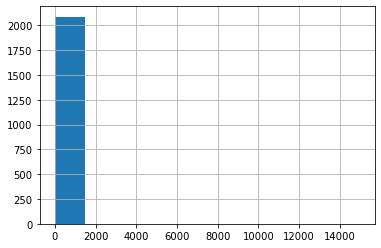

In [26]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count